In [ ]:
import numpy as np
import matplotlib.pyplot as plt

case = 'mean'
path = "/home/jorge.gacitua/experimentos/CrossSection_Assimilation/Data/"
path1 =  f'{path}output_Ntemp1_alpha1_8var_Rloc_5_{case}.npz'
path2 =  f'{path}output_Ntemp2_alpha1_8var_Rloc_5_{case}.npz'
path3 =  f'{path}output_Ntemp3_alpha1_8var_Rloc_5_{case}.npz'

data1 = np.load(path1)
data2 = np.load(path2)
data3 = np.load(path3)

xa1    = data1['xatemp'][:]
atemp1 = data1['obs_error_temp'][:]
print('Shape xa1', xa1.shape)
print(f'steps {atemp1}')

xa2    = data2['xatemp'][:]
atemp2 = data2['obs_error_temp'][:]
print('Shape xa2', xa2.shape)
print(f'steps {atemp2}')

xa3    = data3['xatemp'][:]
atemp3 = data3['obs_error_temp'][:]
print('Shape xa3', xa3.shape)
print(f'steps {atemp3}')


Shape xa1 (121, 1, 100, 29, 8, 2)
steps [1.]
Shape xa2 (121, 1, 100, 29, 8, 3)
steps [0.18242552 0.81757448]
Shape xa3 (121, 1, 100, 29, 8, 4)
steps [0.04389628 0.3243521  0.63175162]


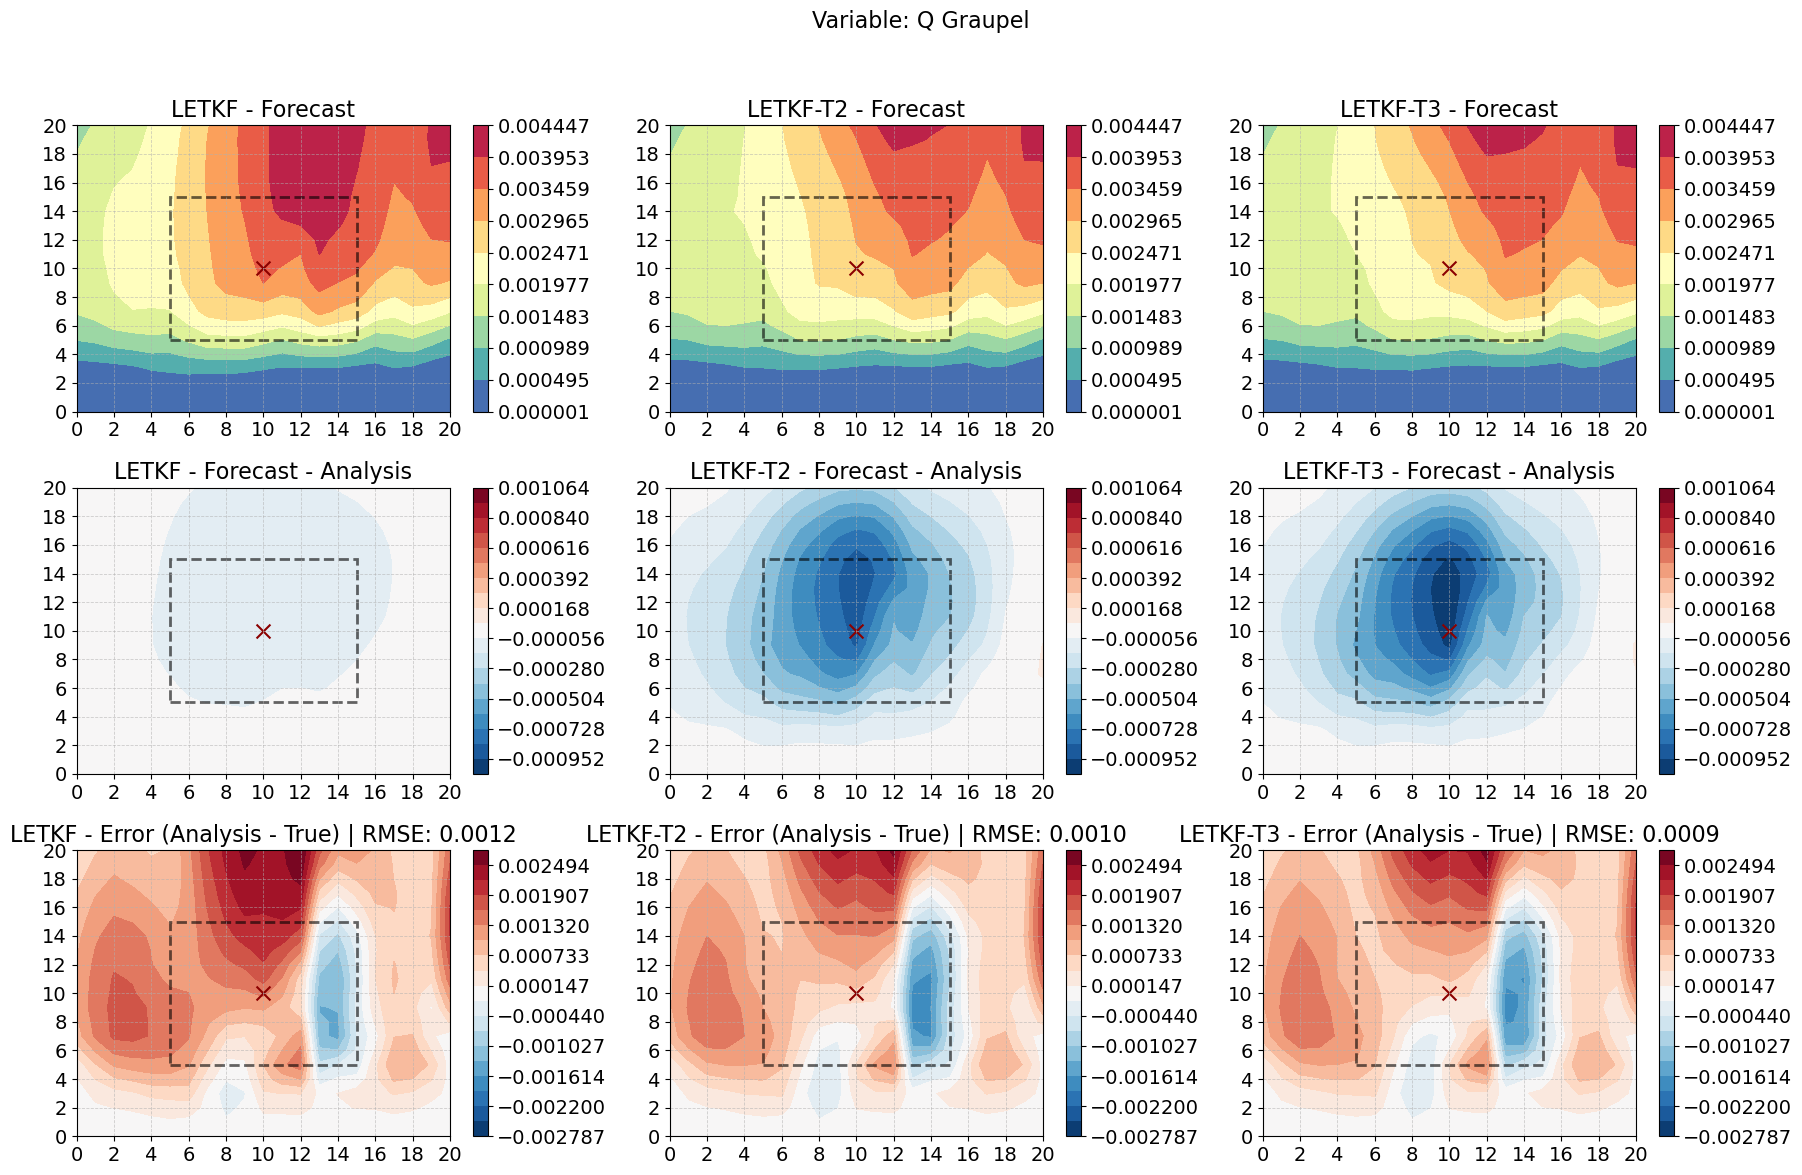

In [22]:
import numpy as np
import matplotlib.pyplot as plt

path = "/home/jorge.gacitua/experimentos/CrossSection_Assimilation/Data/"

# Define file paths
case = 'mean'
file_paths = {
    'LETKF': f'{path}output_Ntemp1_alpha2_8var_Rloc_5_{case}.npz',
    'LETKF-T2': f'{path}output_Ntemp2_alpha2_8var_Rloc_5_{case}.npz',
    'LETKF-T3': f'{path}output_Ntemp3_alpha2_8var_Rloc_5_{case}.npz'
}

# Variable names
variables = {
    0: 'Q Graupel',
    #1: 'Q Rain',
    #2: 'Q Snow',
    #3: 'Temperature',
    #5: 'u',
    #6: 'v',
    #7: 'w'
}

r_loc = 5  # Localization radius

for var_index, var_name in variables.items():
    ncols = len(file_paths)
    fig, axs = plt.subplots(3, ncols, figsize=(6 * ncols, 12))

    contour_levels = {}  # Store contour levels and ticks per row
    vmin_fields = []
    vmax_fields = []
    diff_maxs = []
    err_maxs = []

    for col_index, (col_name, file_path) in enumerate(file_paths.items()):
        data = np.load(file_path)

        obs_loc_x = data['obs_loc_x'][0]
        obs_loc_z = data['obs_loc_z'][0]

        x_start, x_end = obs_loc_x - 2 * r_loc, obs_loc_x + 2 * r_loc + 1
        z_start, z_end = obs_loc_z - 2 * r_loc, obs_loc_z + 2 * r_loc + 1

        xa = data['xatemp'][x_start:x_end, 0, z_start:z_end, :, :, -1]
        xf = data['xf'][x_start:x_end, 0, z_start:z_end, :, :]
        true_state = data['true_state'][x_start:x_end, 0, z_start:z_end, :]

        mean_xa = np.mean(xa, axis=2)
        mean_xf = np.mean(xf, axis=2)

        forecast_field = mean_xf[:, :, var_index]
        analysis_field = mean_xa[:, :, var_index]
        true_field = true_state[:, :, var_index]

        diff_forecast_analysis = forecast_field - analysis_field
        error_analysis = analysis_field - true_field

        vmin_fields.append(np.nanmin(forecast_field))
        vmax_fields.append(np.nanmax(forecast_field))
        diff_maxs.append(np.nanmax(np.abs(diff_forecast_analysis)))
        err_maxs.append(np.nanmax(np.abs(error_analysis)))


    vmin_field=np.nanmin(vmin_fields)
    vmax_field=np.nanmax(vmax_fields)
    contour_levels['field'] = np.linspace(vmin_field, vmax_field, 10)

    diff_max = np.nanmax(diff_maxs)
    contour_levels['diff'] = np.linspace(-diff_max, diff_max, 20)

    err_max = np.nanmax(err_maxs)
    contour_levels['error'] = np.linspace(-err_max, err_max, 20)

    for col_index, (col_name, file_path) in enumerate(file_paths.items()):
        data = np.load(file_path)

        obs_loc_x = data['obs_loc_x'][0]
        obs_loc_z = data['obs_loc_z'][0]

        x_start, x_end = obs_loc_x - 2 * r_loc, obs_loc_x + 2 * r_loc + 1
        z_start, z_end = obs_loc_z - 2 * r_loc, obs_loc_z + 2 * r_loc + 1

        xa = data['xatemp'][x_start:x_end, 0, z_start:z_end, :, :, -1]
        xf = data['xf'][x_start:x_end, 0, z_start:z_end, :, :]
        true_state = data['true_state'][x_start:x_end, 0, z_start:z_end, :]

        mean_xa = np.mean(xa, axis=2)
        mean_xf = np.mean(xf, axis=2)

        forecast_field = mean_xf[:, :, var_index]
        analysis_field = mean_xa[:, :, var_index]
        true_field = true_state[:, :, var_index]

        diff_forecast_analysis = analysis_field - forecast_field
        error_analysis = analysis_field - true_field
        obs_error_temp = data['obs_error_temp'][:]
        # Forecast
        im0 = axs[0, col_index].contourf(analysis_field.T, cmap='Spectral_r', levels=contour_levels['field'])
        cb0 = fig.colorbar(im0, ax=axs[0, col_index])
        axs[0, col_index].set_title(f"{col_name} - Forecast")

        # Forecast - Analysis Difference
        im1 = axs[1, col_index].contourf(diff_forecast_analysis.T, cmap='RdBu_r', levels=contour_levels['diff'])
        cb1 = fig.colorbar(im1, ax=axs[1, col_index])
        axs[1, col_index].set_title(f"{col_name} - Forecast - Analysis")

        # Compute RMSE inside the square
        square_x_start, square_x_end = 2 * r_loc - r_loc, 2 * r_loc + r_loc
        square_z_start, square_z_end = 2 * r_loc - r_loc, 2 * r_loc + r_loc
        square_error = error_analysis[square_x_start:square_x_end, square_z_start:square_z_end]
        rmse = np.sqrt(np.nanmean(square_error**2))

        # Analysis Error
        im2 = axs[2, col_index].contourf(error_analysis.T, cmap='RdBu_r', levels=contour_levels['error'])
        cb2 = fig.colorbar(im2, ax=axs[2, col_index])
        axs[2, col_index].set_title(f"{col_name} - Error (Analysis - True) | RMSE: {rmse:.4f}")

        # Grid every 2 units and add square
        for ax in axs[:, col_index]:
            ax.grid(True, which='major', linestyle='--', linewidth=0.6, alpha=0.6)
            ax.set_xticks(np.arange(0, forecast_field.shape[0], 2))
            ax.set_yticks(np.arange(0, forecast_field.shape[1], 2))

            # Scatter point
            ax.scatter(2 * r_loc, 2 * r_loc, color="DarkRed", marker='x', s=100)

            # Square region
            rect = plt.Rectangle((2 * r_loc - r_loc, 2 * r_loc - r_loc), 2 * r_loc, 2 * r_loc,
                                 linewidth=2, edgecolor='black', facecolor='none', linestyle='--', alpha=0.6)
            ax.add_patch(rect)

    # General title
    fig.suptitle(f"Variable: {var_name}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()



Processing case: below
Saved: figures/below_Q_Graupel.png


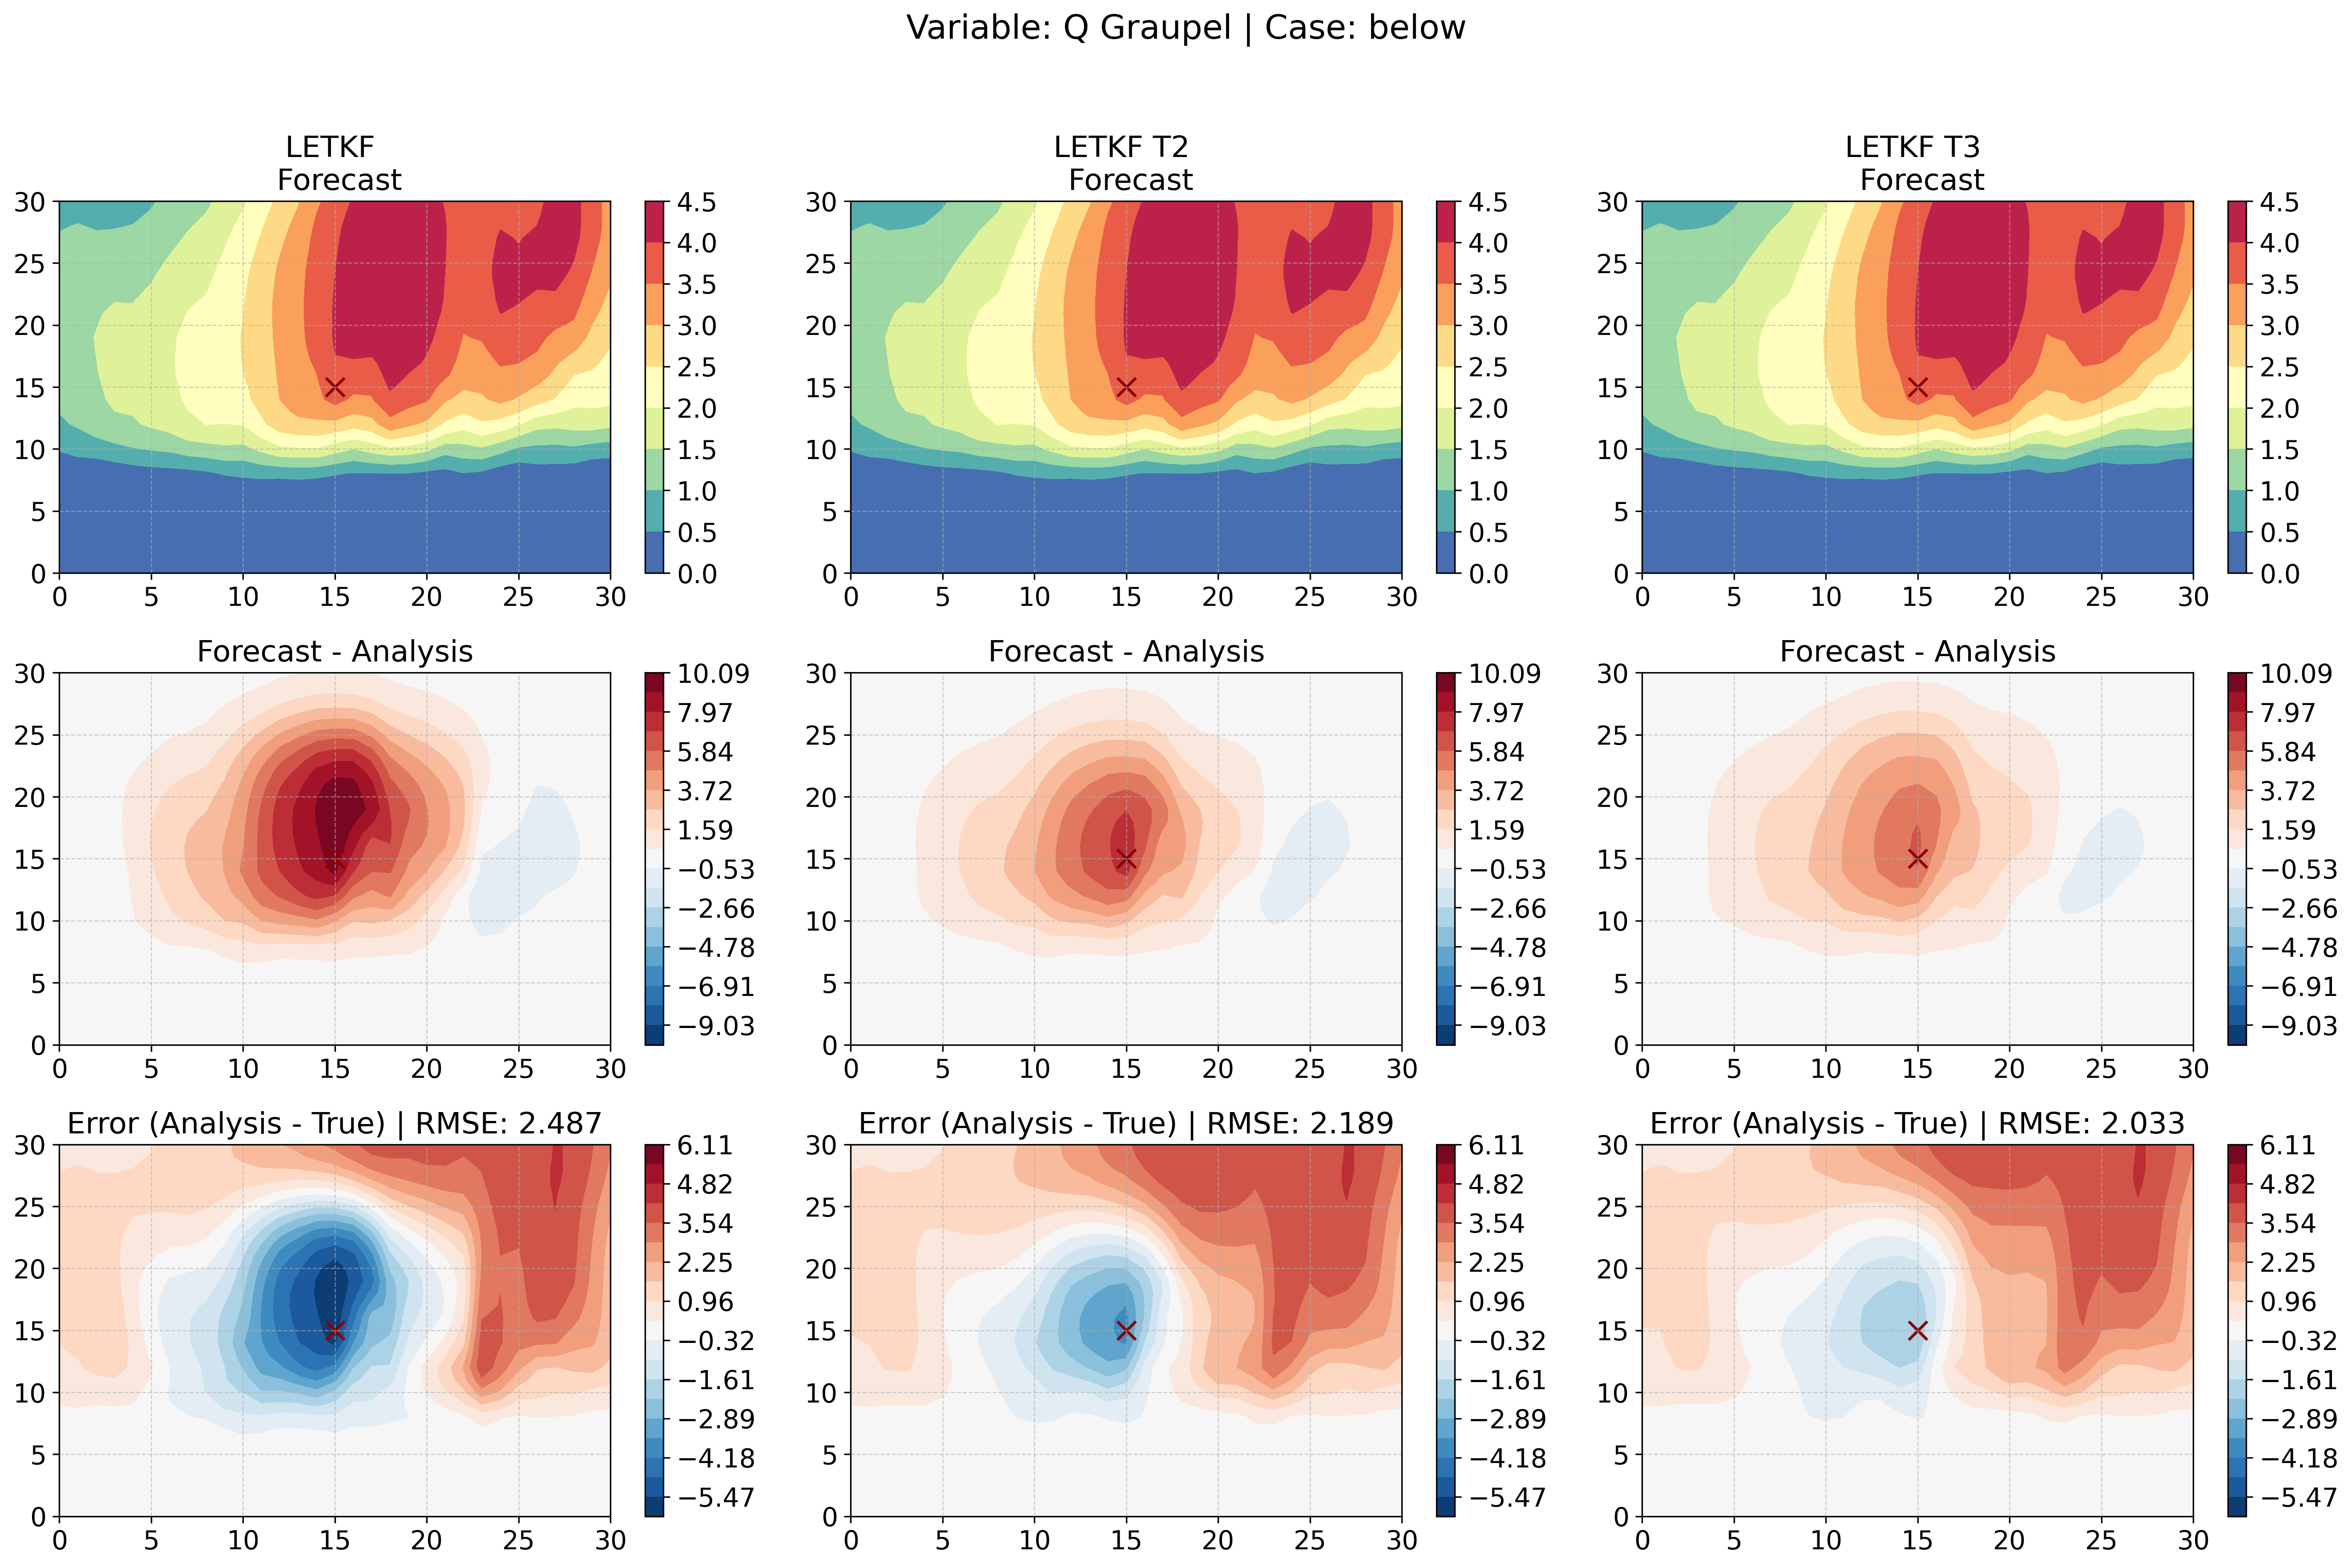

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Increase font sizes
plt.rc('font', size=14)          # controls default text sizes
plt.rc('axes', titlesize=16)     # fontsize of the axes title
plt.rc('axes', labelsize=14)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=14)    # legend fontsize
plt.rc('figure', titlesize=18)   # fontsize of the figure title


# Define output directory
output_dir = "figures"
os.makedirs(output_dir, exist_ok=True)  # Create folder if it doesn’t exist

path = "/home/jorge.gacitua/experimentos/CrossSection_Assimilation/Data/"

# Define cases
cases = ["below"]#["mean", "below", "above"]

# Variable names
variables = {
    0: 'Q Graupel',
    #1: 'Q Rain',
    #2: 'Q Snow',
    #3: 'Temperature',
    #5: 'u',
    #6: 'v',
    #7: 'w'
}

r_loc = 5  # Localization radius

for case in cases:
    print(f"Processing case: {case}")

    # Define file paths
    file_paths = {
        '1 Iterations': f'{path}output_Ntemp1_alpha1_8var_Rloc_5_{case}.npz',
        '2 Iterations': f'{path}output_Ntemp2_alpha1_8var_Rloc_5_{case}.npz',
        '3 Iterations': f'{path}output_Ntemp3_alpha1_8var_Rloc_5_{case}.npz'
    }

    for var_index, var_name in variables.items():
        ncols = len(file_paths)
        fig, axs = plt.subplots(3, ncols, figsize=(6 * ncols, 12), dpi = 300)
        if var_index < 3:
            factor = 1e3
        else:
            factor = 1

        contour_levels = {}  # Store contour levels per row
        vmin_fields = []
        vmax_fields = []
        diff_maxs = []
        err_maxs = []

        # First pass to determine shared levels
        for col_index, (col_name, file_path) in enumerate(file_paths.items()):
            data = np.load(file_path)

            obs_loc_x = data['obs_loc_x'][0]
            obs_loc_z = data['obs_loc_z'][0]

            x_start, x_end = obs_loc_x - 3 * r_loc, obs_loc_x + 3 * r_loc + 1
            z_start, z_end = obs_loc_z - 3 * r_loc, obs_loc_z + 3 * r_loc + 1

            xa = data['xatemp'][x_start:x_end, 0, z_start:z_end, :, :, -1]*factor
            xf = data['xf'][x_start:x_end, 0, z_start:z_end, :, :]*factor
            true_state = data['true_state'][x_start:x_end, 0, z_start:z_end, :]*factor

            mean_xa = np.mean(xa, axis=2)
            mean_xf = np.mean(xf, axis=2)

            forecast_field = mean_xf[:, :, var_index]
            analysis_field = mean_xa[:, :, var_index]
            true_field = true_state[:, :, var_index]

            diff_forecast_analysis = forecast_field - analysis_field
            error_analysis = analysis_field - true_field

            vmin_fields.append(np.nanmin(forecast_field))
            vmax_fields.append(np.nanmax(forecast_field))
            diff_maxs.append(np.nanmax(np.abs(diff_forecast_analysis)))
            err_maxs.append(np.nanmax(np.abs(error_analysis)))

        vmin_field = np.nanmin(vmin_fields)
        vmax_field = np.nanmax(vmax_fields)
        contour_levels['field'] = np.linspace(vmin_field, vmax_field, 10)

        diff_max = np.nanmax(diff_maxs)
        contour_levels['diff'] = np.linspace(-diff_max, diff_max, 20)

        err_max = np.nanmax(err_maxs)
        contour_levels['error'] = np.linspace(-err_max, err_max, 20)

        # Second pass to plot with the determined levels
        for col_index, (col_name, file_path) in enumerate(file_paths.items()):
            data = np.load(file_path)

            obs_loc_x = data['obs_loc_x'][0]
            obs_loc_z = data['obs_loc_z'][0]

            x_start, x_end = obs_loc_x - 3 * r_loc, obs_loc_x + 3 * r_loc + 1
            z_start, z_end = obs_loc_z - 3 * r_loc, obs_loc_z + 3 * r_loc + 1

            xa = data['xatemp'][x_start:x_end, 0, z_start:z_end, :, :, -1]*factor
            xf = data['xf'][x_start:x_end, 0, z_start:z_end, :, :]*factor
            true_state = data['true_state'][x_start:x_end, 0, z_start:z_end, :]*factor

            mean_xa = np.mean(xa, axis=2)
            mean_xf = np.mean(xf, axis=2)

            forecast_field = mean_xf[:, :, var_index]
            analysis_field = mean_xa[:, :, var_index]
            true_field = true_state[:, :, var_index]

            diff_forecast_analysis = analysis_field-forecast_field#forecast_field - analysis_field
            error_analysis = analysis_field - true_field

            # Forecast
            im0 = axs[0, col_index].contourf(analysis_field.T, cmap='Spectral_r', levels=contour_levels['field'])
            fig.colorbar(im0, ax=axs[0, col_index])
            if col_index == 0:
                axs[0, col_index].set_title(f"LETKF \n Analysis")
            elif col_index == 1:
                axs[0, col_index].set_title(f"LETKF T2 \n Analysis")
            else:
                axs[0, col_index].set_title(f"LETKF T3 \n Analysis")

            # Forecast - Analysis Difference
            im1 = axs[1, col_index].contourf(diff_forecast_analysis.T, cmap='RdBu_r', levels=contour_levels['diff'])
            fig.colorbar(im1, ax=axs[1, col_index])
            axs[1, col_index].set_title(f"Forecast - Analysis")

            # Compute RMSE inside the square
            square_x_start, square_x_end = r_loc, 6 * r_loc
            square_z_start, square_z_end = r_loc, 6 * r_loc
            square_error = error_analysis[square_x_start:square_x_end, square_z_start:square_z_end]
            rmse = np.sqrt(np.nanmean(square_error**2))

            # Analysis Error
            im2 = axs[2, col_index].contourf(error_analysis.T, cmap='RdBu_r', levels=contour_levels['error'])
            fig.colorbar(im2, ax=axs[2, col_index])
            axs[2, col_index].set_title(f"Error (Analysis - True) | RMSE: {rmse:.3f}")

            # Grid every 2 units and add square
            for ax in axs[:, col_index]:
                ax.grid(True, which='major', linestyle='--', linewidth=0.6, alpha=0.6)
                ax.set_xticks(np.arange(0, forecast_field.shape[0], 5))
                ax.set_yticks(np.arange(0, forecast_field.shape[1], 5))

                # Scatter point with white border
                ax.scatter(3 * r_loc, 3 * r_loc, color="DarkRed", linewidth=1.5, marker='x', s=100)

        # General title
        fig.suptitle(f"Variable: {var_name} | Case: {case}", fontsize=18)
        plt.tight_layout(rect=[0, 0, 1, 0.96])

        # Save figure in `figures/`
        output_filename = f"{output_dir}/{case}_{var_name.replace(' ', '_')}.png"
        plt.savefig(output_filename, dpi=300, bbox_inches="tight")
        print(f"Saved: {output_filename}")
        plt.show()
        #plt.close(fig)  # Close figure to save memory


In [19]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Increase font sizes
plt.rc('font', size=14)          # controls default text sizes
plt.rc('axes', titlesize=16)     # fontsize of the axes title
plt.rc('axes', labelsize=14)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=14)    # legend fontsize
plt.rc('figure', titlesize=18)   # fontsize of the figure title


# Define output directory
output_dir = "figures"
os.makedirs(output_dir, exist_ok=True)  # Create folder if it doesn’t exist

path = "/home/jorge.gacitua/experimentos/CrossSection_Assimilation/Data/"

# Define cases
cases = ["mean", "below", "above"]

# Variable names
variables = {
    0: 'Q Graupel',
    1: 'Q Rain',
    2: 'Q Snow',
    3: 'Temperature',
    4: 'Pressure',
    5: 'u',
    6: 'v',
    7: 'w'
}
all_rmse = np.zeros((len(cases), len(variables), 3))
rmse_values = {case: np.zeros((len(variables), 3)) for case in cases}
r_loc = 5  # Localization radius

for case in cases:
    print(f"Processing case: {case}")

    # Define file paths
    file_paths = {
        '1 Iterations': f'{path}output_Ntemp1_alpha1_8var_Rloc_5_{case}.npz',
        '2 Iterations': f'{path}output_Ntemp2_alpha1_8var_Rloc_5_{case}.npz',
        '3 Iterations': f'{path}output_Ntemp3_alpha1_8var_Rloc_5_{case}.npz'
    }

    for var_index, var_name in variables.items():
        if var_index < 3:
            factor = 1e3
        else:
            factor = 1
        # Second pass to plot with the determined levels
        for col_index, (col_name, file_path) in enumerate(file_paths.items()):
            data = np.load(file_path)

            obs_loc_x = data['obs_loc_x'][0]
            obs_loc_z = data['obs_loc_z'][0]

            x_start, x_end = obs_loc_x - 3 * r_loc, obs_loc_x + 3 * r_loc + 1
            z_start, z_end = obs_loc_z - 3 * r_loc, obs_loc_z + 3 * r_loc + 1

            xa = data['xatemp'][x_start:x_end, 0, z_start:z_end, :, :, -1]*factor
            true_state = data['true_state'][x_start:x_end, 0, z_start:z_end, :]*factor

            mean_xa = np.mean(xa, axis=2)
            analysis_field = mean_xa[:, :, var_index]
            true_field = true_state[:, :, var_index]

            error_analysis = analysis_field - true_field

            # Compute RMSE inside the square
            square_x_start, square_x_end = r_loc, 6 * r_loc
            square_z_start, square_z_end = r_loc, 6 * r_loc
            square_error = error_analysis[square_x_start:square_x_end, square_z_start:square_z_end]
            rmse = np.sqrt(np.nanmean(square_error**2))
            all_rmse[cases.index(case), var_index, col_index] = rmse
            rmse_values[case][var_index, col_index] = rmse



Processing case: mean
Processing case: below
Processing case: above


In [25]:
import numpy as np
import pandas as pd

# Define the variables
variables = ['Q Graupel', 'Q Rain', 'Q Snow', 'Temperature','Pressure', 'u', 'v', 'w']
cases = ["mean", "below", "above"]
iterations = ["1 Iter", "2 Iter", "3 Iter"]

# Simulated RMSE values (Replace this with actual RMSE calculations)
#rmse_values = {case: np.zeros(len(variables), len(iterations)) for case in cases}

# Compute reduction percentages
rmse_reductions = {case: np.zeros((len(variables), 2)) for case in cases}

for case in cases:
    for i in range(len(variables)):
        rmse_reductions[case][i, 0] = ((rmse_values[case][i, 1] - rmse_values[case][i, 0]) / rmse_values[case][i, 0]) * 100
        rmse_reductions[case][i, 1] = ((rmse_values[case][i, 2] - rmse_values[case][i, 0]) / rmse_values[case][i, 0]) * 100

# Creating the structured table
columns = [
    "LETKF", "LETKF T2 %", "LETKF T3 %",
    "LETKF", "LETKF T2 %", "LETKF T3 %",
    "LETKF", "LETKF T2 %", "LETKF T3 %"
]

table_values = np.hstack([
    rmse_values["mean"][:, [0]], rmse_reductions["mean"],
    rmse_values["below"][:, [0]], rmse_reductions["below"],
    rmse_values["above"][:, [0]], rmse_reductions["above"]
])

# Create DataFrame
#df = pd.DataFrame(table_values, columns=columns, index=variables)

# Print table in a readable format
#print(df)

# Save table as CSV
#df.to_csv("rmse_table.csv", index=True)
#print("Table saved as rmse_table.csv")
# Create MultiIndex columns
cases_labels = ["Closest to Mean"] * 3 + ["Underestimation"] * 3 + ["Overestimation"] * 3
method_labels = ["LETKF", "LETKF T2 %", "LETKF T3 %"] * 3
multi_columns = pd.MultiIndex.from_tuples(zip(cases_labels, method_labels))

# Stack values for all cases into one array
table_values = np.hstack([
    rmse_values["mean"][:, [0]], rmse_reductions["mean"],
    rmse_values["below"][:, [0]], rmse_reductions["below"],
    rmse_values["above"][:, [0]], rmse_reductions["above"]
])

# Create DataFrame
df = pd.DataFrame(table_values, columns=multi_columns, index=variables)

# Save
df.to_csv("rmse_table.csv")
print("Table saved as rmse_table.csv")

Table saved as rmse_table.csv


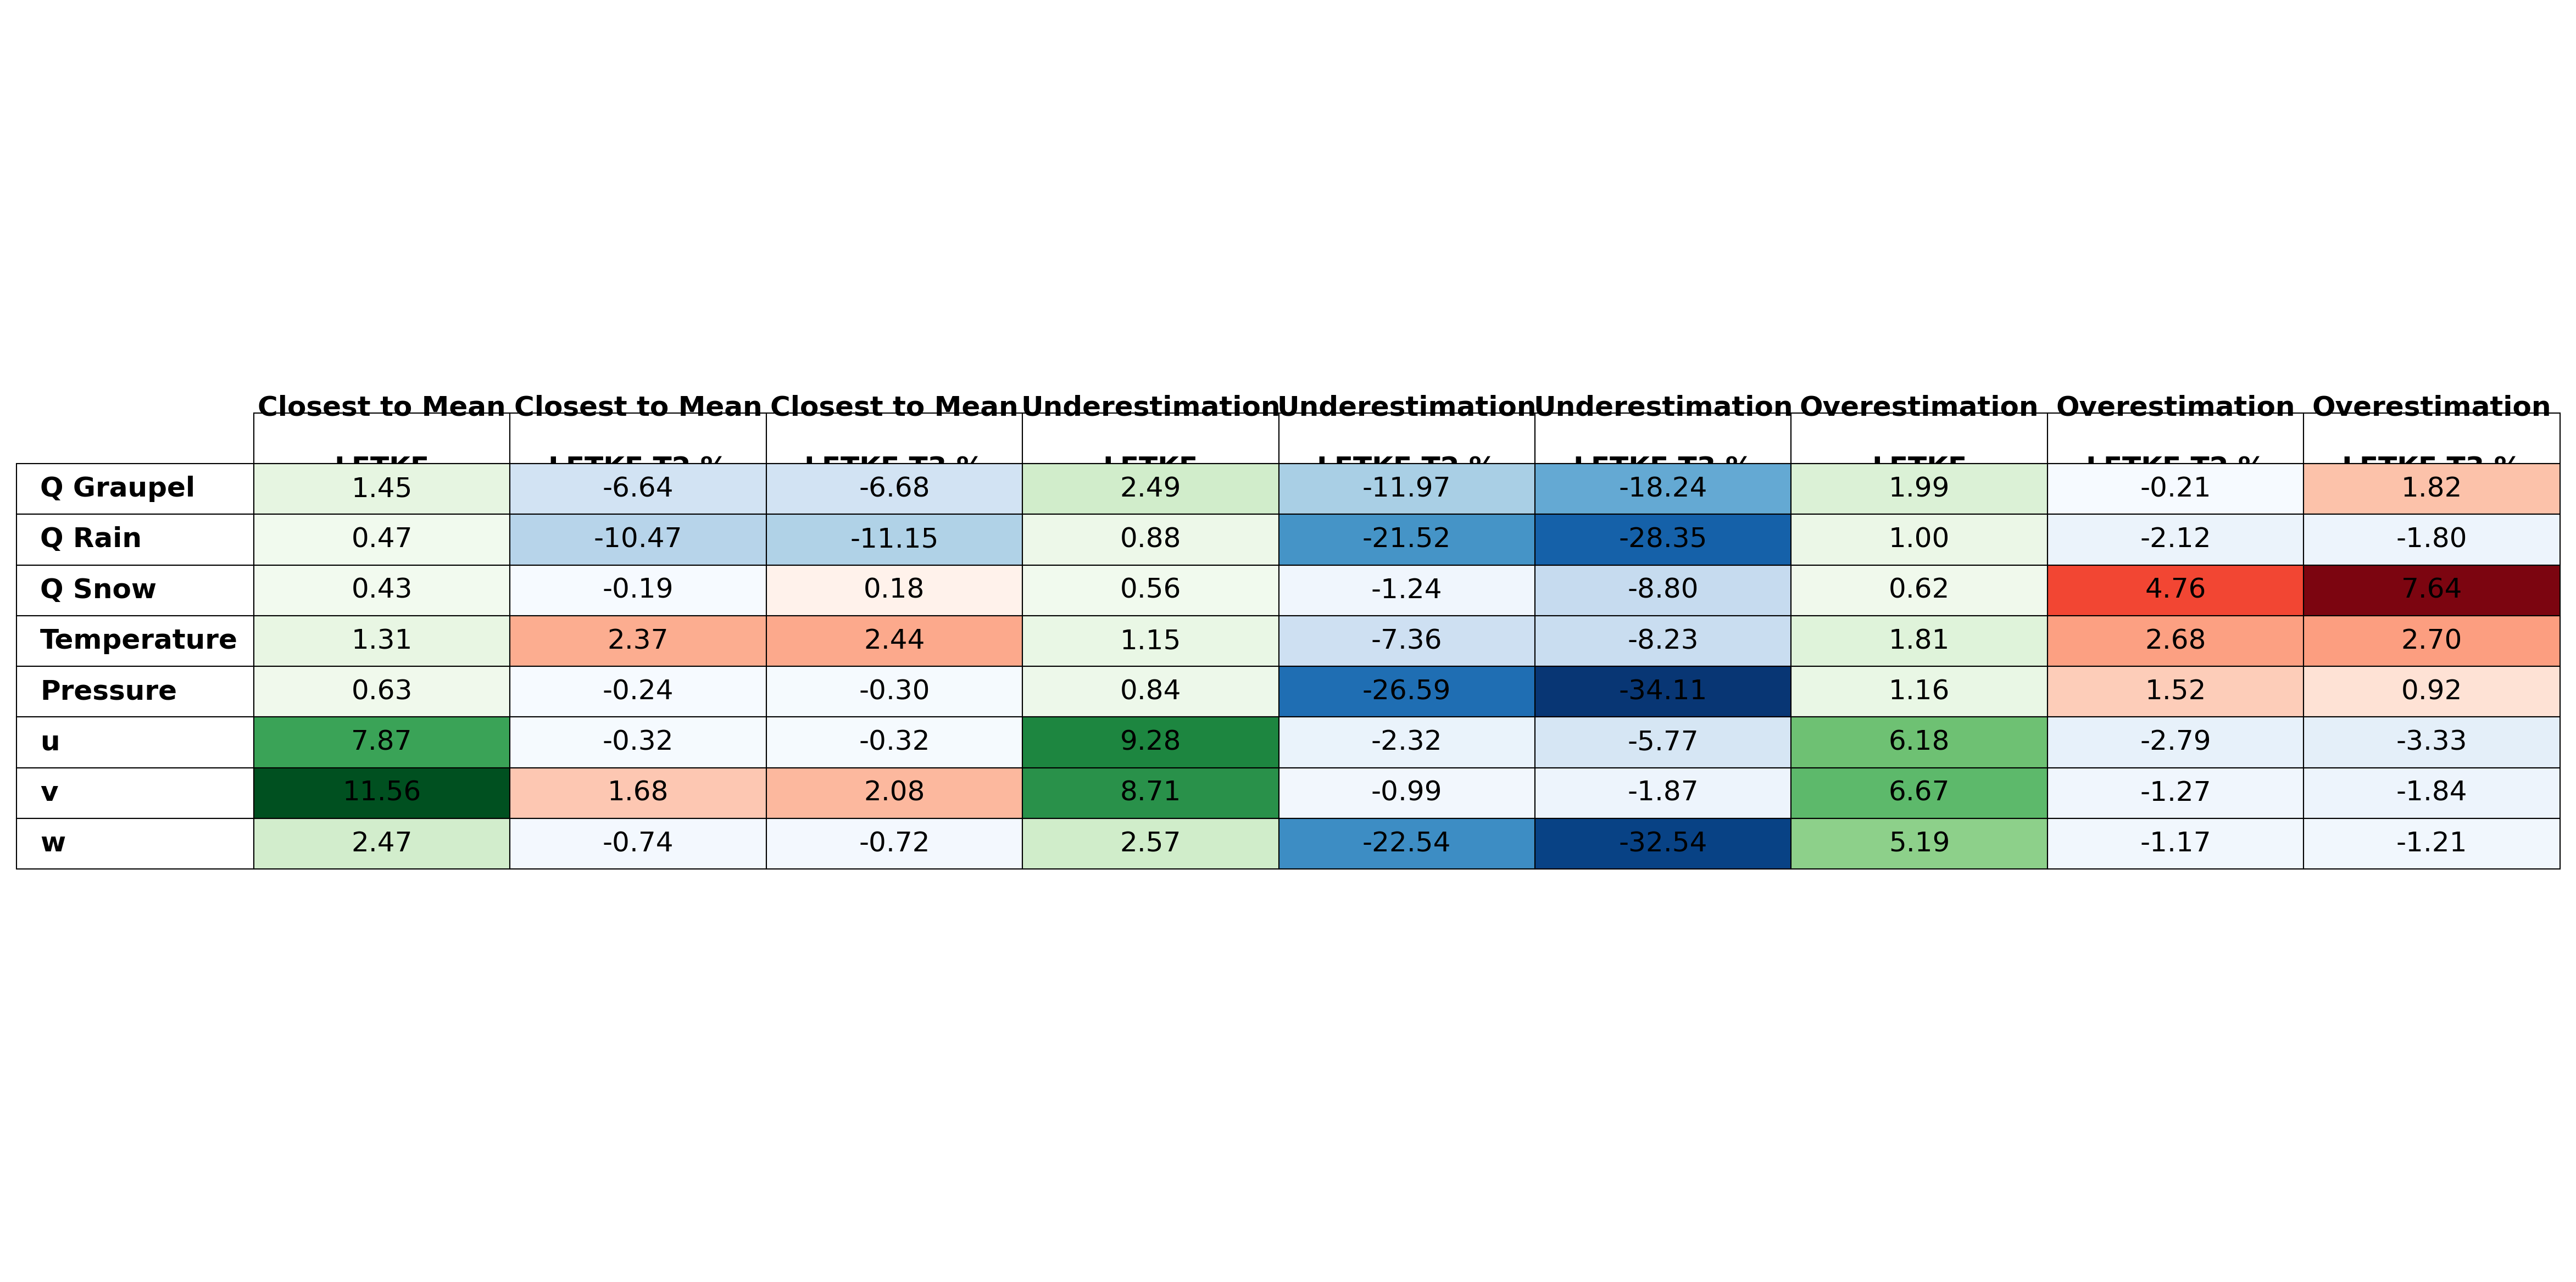

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# Load data
#df = pd.read_csv("rmse_table.csv", index_col=0)
df = pd.read_csv("rmse_table.csv", header=[0, 1], index_col=0)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(16, 8), dpi=300)
ax.axis('off')  # turn off the axes

# Normalize color range for reduction percentage columns
cmap_neg = plt.cm.Blues_r  # Reversed Blues for negative values
cmap_pos = plt.cm.Reds
cmap_values = plt.cm.Greens     # Reds for positive values

# Create a color function
def get_color(val, is_percentage):
    if not is_percentage:
        norm = mcolors.Normalize(vmin=0, vmax=12)
        return cmap_values(norm(val)) # Default background for raw LETKF RMSE
    if val < 0:
        # Normalize between -40 and 0
        norm = mcolors.Normalize(vmin=-35, vmax=0)
        return cmap_neg(norm(val))
    else:
        # Normalize between 0 and +10
        norm = mcolors.Normalize(vmin=0, vmax=8)
        return cmap_pos(norm(val))

# Convert values to string with two decimals
cell_text = []
cell_colors = []

for i, row in df.iterrows():
    row_text = []
    row_colors = []
    for j, val in enumerate(row):
        val_str = f"{val:.2f}"
        row_text.append(val_str)

        is_percentage = "%" in df.columns[j][1]
        row_colors.append(get_color(val, is_percentage))

    cell_text.append(row_text)
    cell_colors.append(row_colors)

# Plot the table
table = ax.table(
    cellText=cell_text,
    rowLabels=df.index,
    colLabels=[f"{grp}\n\n{meth}" for grp, meth in df.columns],#df.columns,
    cellColours=cell_colors,
    loc='center',
    cellLoc='center'
)

table.scale(1.2, 1.5)
table.auto_set_font_size(False)
table.set_fontsize(12)

# Optional: bold headers
for (row, col), cell in table.get_celld().items():
    if row == 0 or col == -1:
        cell.set_text_props(weight='bold')
    cell.set_linewidth(0.5)

plt.tight_layout()
#plt.savefig("rmse_colored_table.png", dpi=300)
#plt.savefig("rmse_colored_table.pdf")
plt.show()


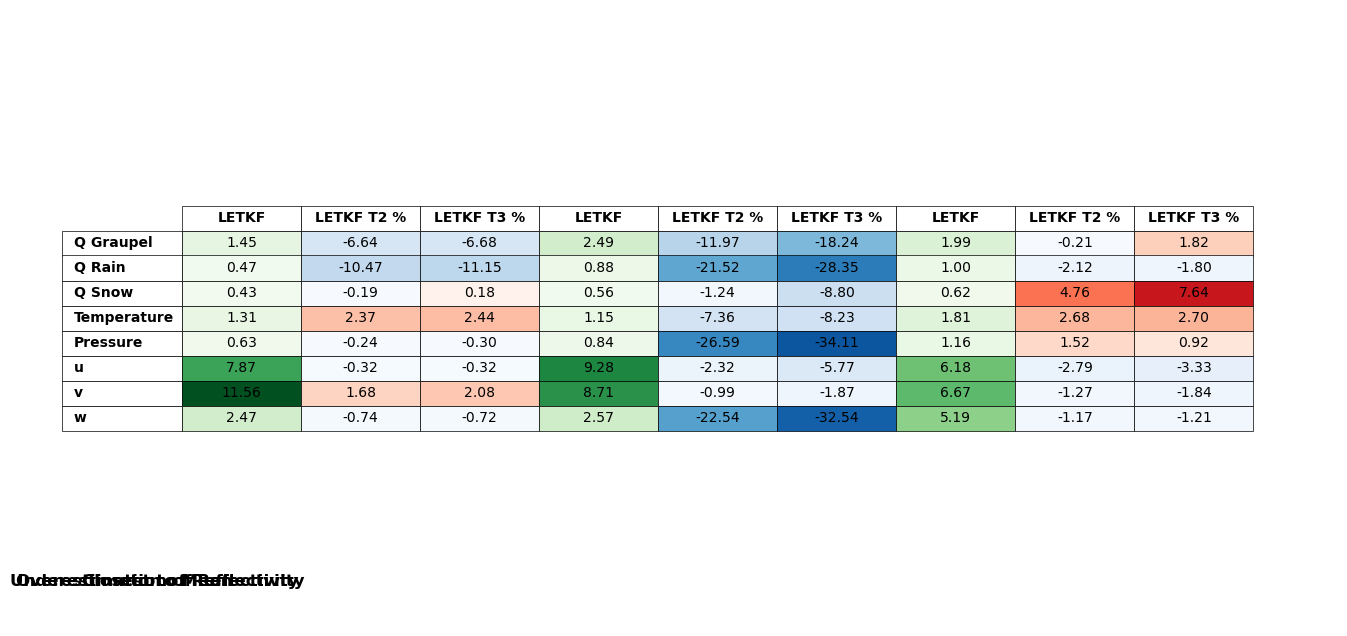

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# Load data with multi-index columns
df = pd.read_csv("rmse_table.csv", header=[0, 1], index_col=0)

fig, ax = plt.subplots(figsize=(16, 8))
ax.axis('off')

# Normalize color range for reduction percentage columns
cmap_neg = plt.cm.Blues_r
cmap_pos = plt.cm.Reds
cmap_raw = plt.cm.Greens

def get_color(val, is_percentage):
    if not is_percentage:
        norm = mcolors.Normalize(vmin=0, vmax=12)
        return cmap_raw(norm(val))
    elif val < 0:
        norm = mcolors.Normalize(vmin=-40, vmax=0)
        return cmap_neg(norm(val))
    else:
        norm = mcolors.Normalize(vmin=0, vmax=10)
        return cmap_pos(norm(val))

# Format cell text and colors
cell_text = []
cell_colors = []

for i, row in df.iterrows():
    row_text = []
    row_colors = []
    for j, val in enumerate(row):
        row_text.append(f"{val:.2f}")
        is_percentage = "%" in df.columns[j][1]
        row_colors.append(get_color(val, is_percentage))
    cell_text.append(row_text)
    cell_colors.append(row_colors)

# Column labels for second level
col_labels = [meth for _, meth in df.columns]
row_labels = [rf"\textbf{{{name}}}" for name in df.index]  # bold row labels (optional)

# Create the table
the_table = ax.table(
    cellText=cell_text,
    rowLabels=df.index,
    colLabels=col_labels,
    cellColours=cell_colors,
    cellLoc='center',
    loc='center',
    colWidths=[0.08] * len(df.columns)
)

# Style the table
the_table.scale(1.2, 1.5)
the_table.auto_set_font_size(False)
the_table.set_fontsize(10)

# Bold the row labels and draw gridlines
for (row, col), cell in the_table.get_celld().items():
    cell.set_linewidth(0.5)
    if row == 0:
        cell.set_text_props(weight='bold')
    if col == -1:
        cell.set_text_props(weight='bold')

# ===============================
# Draw merged top headers manually (aligned version)
# ===============================
# Get table cell dimensions
cell_dict = the_table.get_celld()
first_row_y = cell_dict[0, 0].get_y()
cell_height = cell_dict[0, 0].get_height()
header_y = first_row_y + cell_height + 0.02  # a bit above the column headers

# Compute x positions
header_locs = {
    "Closest to Mean": (0, 3),
    "Underestimation of Reflectivity": (3, 6),
    "Overestimation of Reflectivity": (6, 9),
}

for header, (start, end) in header_locs.items():
    x_start = cell_dict[0, start].get_x()
    x_end = cell_dict[0, end - 1].get_x() + cell_dict[0, end - 1].get_width()
    x_center = (x_start + x_end) / 2

    ax.text(
        x_center,
        header_y,
        header,
        ha='center',
        va='bottom',
        fontsize=12,
        fontweight='bold'
    )
